# Lab 1 in AIH

Welcome to the first lab.  
Below you can see the instructions to proceed with the needed tasks. You should complete the implementation of the functions mentioned below.  
For the lab submission, you should write a report explaining your implementation and showing the results .. You also are required to upload the code with the report.

Have fun :)

# Import packages 

In [1]:
import tensorflow.keras as tf
from tensorflow.keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from tensorflow.keras.layers import Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta, Adam
import os
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_roc_curve, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import time
import pprint
from itertools import cycle

try:
    import nibabel as nib
except:
    raise ImportError('Install NIBABEL')

In [2]:
# GPU to run on
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Visualizing a scan
To se the different sclices of the brain

(79, 95, 79)


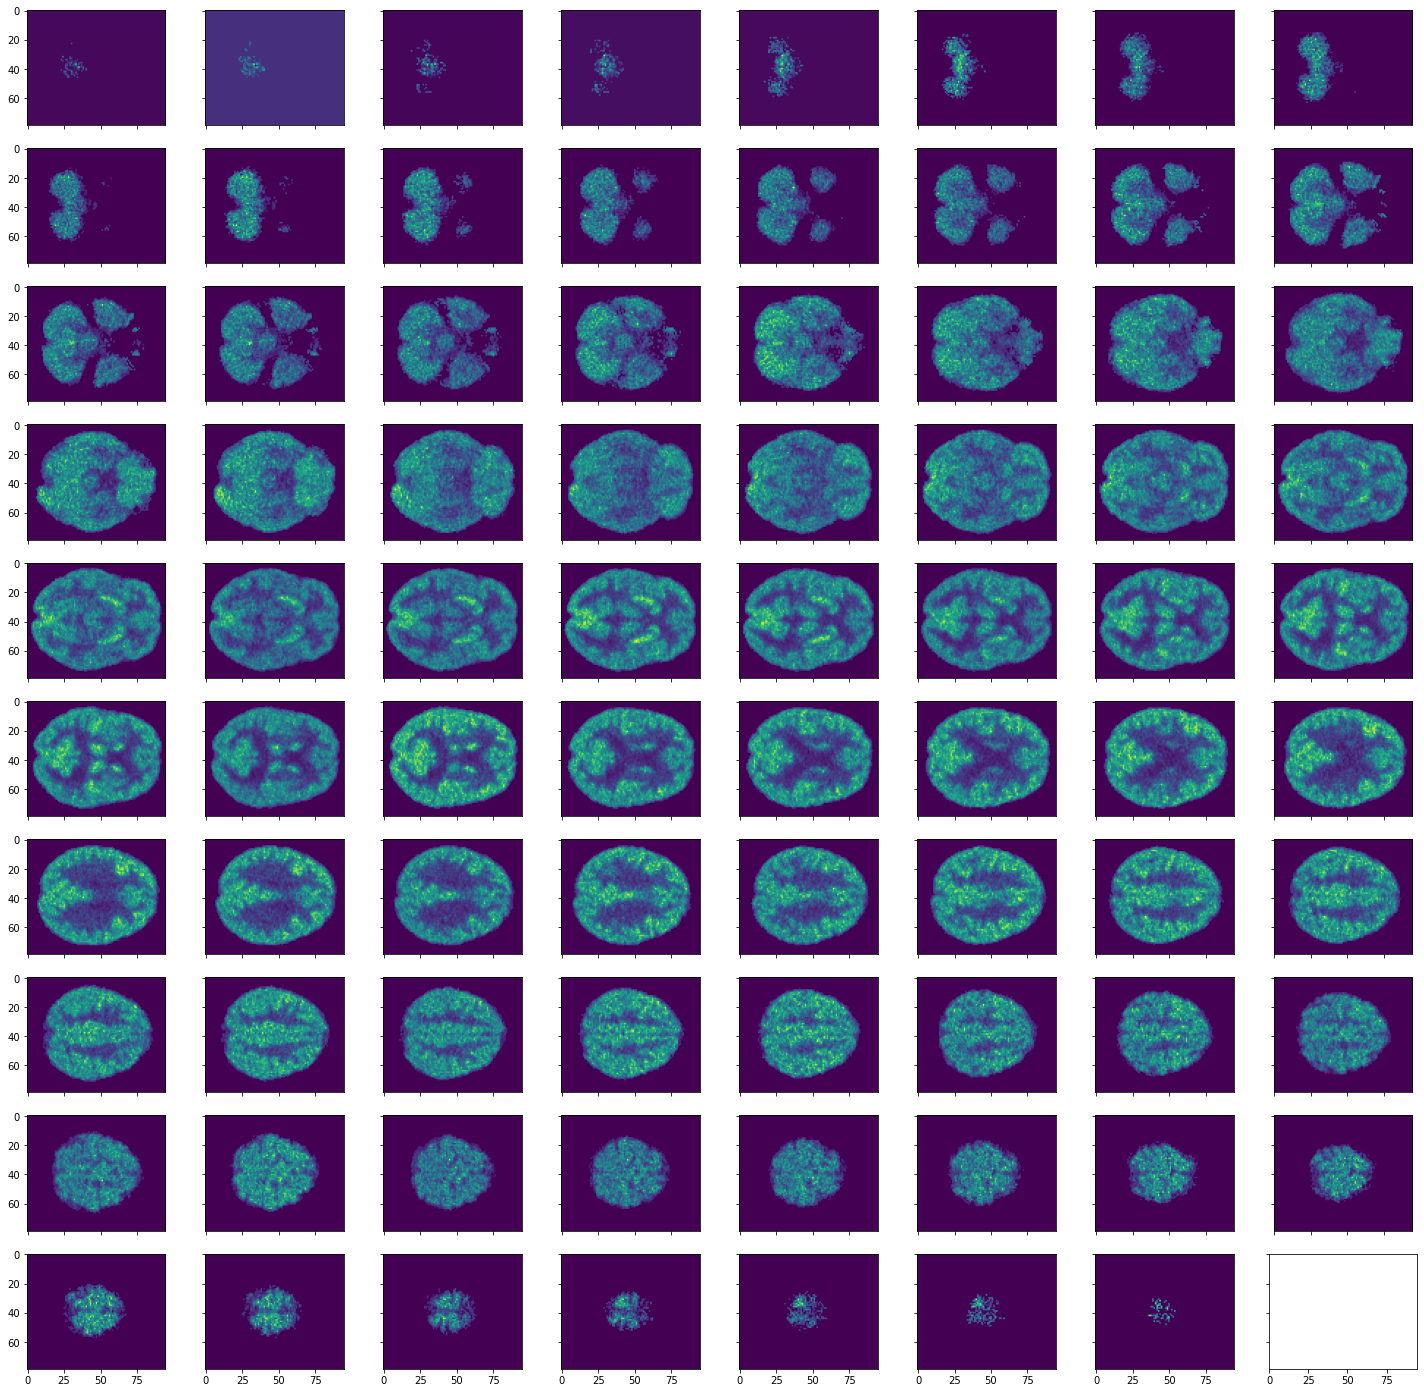

In [3]:
local_normal = os.getcwd() + '/data/AD/AD_ADNI_2489.nii'
pet_img=nib.load(local_normal).get_fdata()
print(pet_img.shape)

fig, axs = plt.subplots(10,8, figsize = (25, 25),sharex='all', sharey='all')
for i in range (10):
    for j in range (8):
        index = i*8 + j
        axs[i,j].imshow(pet_img[:,:,index])
        
        if index+1 > 78:
            break

# Load data & Intensity normalization 

In [4]:
dim_x = 79
dim_y = 95
dim_z = 60 

def load_all_nii_data(path, filenames, category):
    data = np.zeros((len(filenames),dim_x,dim_y, dim_z))
    labels = []
    for i, f in enumerate(filenames):
        pet_img=nib.load(path + f).get_fdata()
        pet_img = intensity_normalize(pet_img)
        labels.append(category)
        data[i,:,:,:] = pet_img[:,:,slice(10, 70, 1)] #Skip the first 10 layers and the last 9
           
    return data, labels

# Normalize individually per each input scan
def intensity_normalize(data):
    data_scaled = (data - data.min())/(data.max() - data.min())
    
    return data_scaled
    
ad_files = os.listdir(os.getcwd() + '/data/AD/')
cn_files = os.listdir(os.getcwd() + '/data/CN/')
mci_files = os.listdir(os.getcwd() + '/data/MCI/')
    
cn_data, cn_labels = load_all_nii_data(os.getcwd() + '/data/CN/', cn_files, 0)
ad_data, ad_labels = load_all_nii_data(os.getcwd() + '/data/AD/', ad_files, 1)
mci_data, mci_labels = load_all_nii_data(os.getcwd() + '/data/MCI/', mci_files, 2)
all_data = np.concatenate((cn_data, ad_data, mci_data), axis=0)
all_labels = np.concatenate((cn_labels, ad_labels, mci_labels), axis=0)

For VGG netowrk you need to provde labels as categorical classes.  
You can use tensorflow.keras.utils.to_categorical.

In [5]:
all_data.shape

(392, 79, 95, 60)

In [6]:
cn_data.shape

(80, 79, 95, 60)

In [7]:
mci_data.shape

(156, 79, 95, 60)

In [8]:
ad_data.shape

(156, 79, 95, 60)

In [9]:
all_labels.shape

(392,)

# Split the data 

Split the data into train and test datasets.  
leave 10% of your data for testing.

In [10]:
def split_data(data, labels):
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1)
    
    return X_train, X_test, y_train, y_test


In [11]:
Xtrain,Xtest, ytrain, ytest = split_data(all_data, all_labels)

# Encode labels

In [12]:
ytrain_enc = tf.utils.to_categorical(ytrain, 3)
ytest_enc = tf.utils.to_categorical(ytest, 3)

# The Model

Creat convolution blocks and MLP.  
Try different values of Dropout. 

In [13]:
# define your VGG model
def create_VGG_3Dmodel(dim_x, dim_y, dim_z):
    
    input_layer = Input((dim_x, dim_y, dim_z, 1))
        
    conv1_1= Conv3D(filters=8,kernel_size=3,padding='same')(input_layer)
    conv1_2= Conv3D(filters=16,kernel_size=3,padding='same')(conv1_1)
    pool1 = MaxPool3D(pool_size=3)(conv1_2)
    conv1 = BatchNormalization()(pool1)
    conv2_1= Conv3D(filters=32,kernel_size=3,padding='same')(conv1)
    conv2_2= Conv3D(filters=64,kernel_size=3,padding='same')(conv2_1)
    pool2 = MaxPool3D(pool_size=3)(conv2_2)
    conv2 = BatchNormalization()(pool2)
    
    flatten = Flatten()(conv2)
    
    dense1 = Dense(4096, activation='relu')(flatten)
    #dropout = Dropout(0.5)(dense1)
    dense2 = Dense(1024, activation='relu')(dense1)
    #dropout = Dropout(0.5)(dense2)
    
    output_layer = Dense(3, activation = "softmax")(dense2)
    # define the model with input layer and output layer
    model = Model(inputs=input_layer, outputs=output_layer)

    return model


In [14]:
create_VGG_3Dmodel(dim_x, dim_y, dim_z)

The next step is to perform the cross validatio, you should try performing it for 15 rounds and in each round you try with k starts from 2 to 10.  
Here is some guidence reagarding optimizer and early stopping conditions:

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adadelta(lr=0.01), metrics=['acc']).

reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=0, patience=5, mode='auto').

early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, verbose=0, patience=10, mode='auto').


Keep in mid to save to the disk the models achieving the highest validation accuracy.  
You also need to store the trainig as well as validation accurcies to create plot with 95% confidence intervals similar to this one.

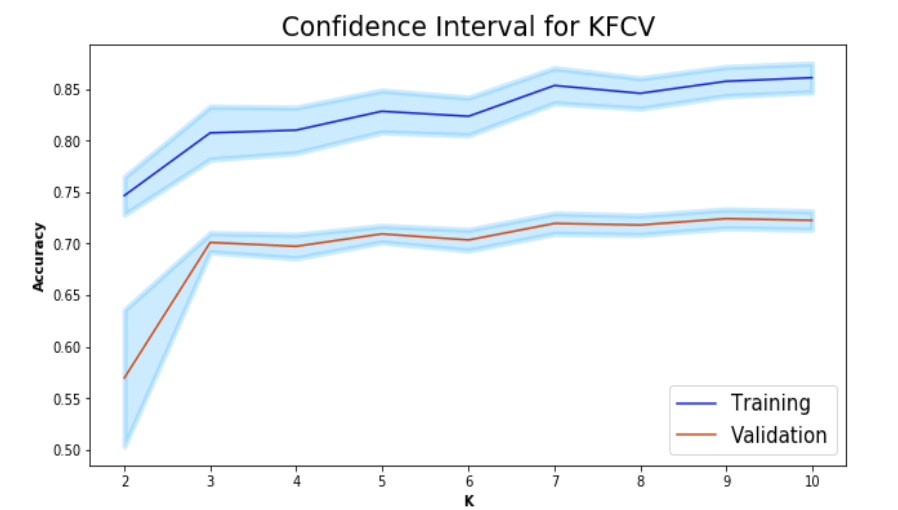

In [15]:
nbr_folds = [5,6,7,8,9,10] # Number of folds
#nbr_folds = [2,3] # For test purposes
train_scores = [] # Accuracy scores on training data.
val_scores = [0] # Accuracy scores on validation data.
avg_k_train_acc = [] #Average of accuracy of every K-fold. 
avg_k_val_acc = [] #Average of validation accuracy of every K-fold. 

temp_model = None # Temporal variable which saves the best performing model.  

# perform the KFCV

reduce = tf.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                        factor=0.1, 
                                        verbose=0, 
                                        patience=5, 
                                        mode='auto')

early = tf.callbacks.EarlyStopping(monitor='val_loss', 
                                   min_delta=1e-4, 
                                   verbose=0, 
                                   patience=10, 
                                   mode='auto')

start = time.time() # Start timer
for nbr_of_folds in nbr_folds: 
    train_acc = []
    val_acc = []
    
    # Define the K-fold Cross Validator
    kfold = KFold(nbr_of_folds, shuffle=True)
    
    model = create_VGG_3Dmodel(dim_x, dim_y, dim_z)
    # Compile the model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=tf.optimizers.Adadelta(lr=0.01), 
                  metrics=['acc'])
    
    # If the list is empty then print "list is empty" else append 'train_acc' to 'avg_k_train_acc'
    if not train_acc:
        print("List is empty")
    elif train_acc:
        avg_k_train_acc.append(np.average(train_acc))
        
    print(f'First print of Train Acc: {train_acc}') # To verify that the list is empty 
    print(f'First print of avg_k_train:{avg_k_train_acc}') # To verify that the list does not contain nans
    
    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(Xtrain, ytrain):
        
        print('---------- TRAINING MODEL', fold_no, 'of', nbr_of_folds, 'FOLDS ----------')
        # Fit data to model
        history = model.fit(Xtrain[train], ytrain_enc[train],
                  batch_size=5,
                  #batch_size=2,
                  epochs=50, 
                  #epochs=2,
                  callbacks = [reduce, early],
                  validation_data = (Xtrain[test], ytrain_enc[test])
                           )
        # Print Time it took to run 
        elapsed = time.time() - start
        print(f'Elapsed time: {int(elapsed // 86400)}d {int((elapsed%86400) // 3600)}h {int((elapsed // 60) % 60)}m {int(elapsed%60)}s')
        
        train_acc.append(np.average(history.history['acc'])) # Append train accuracy to 'train_acc'
        print(f'Second print of Train Acc: {train_acc}') # For test puposes
        val_acc.append(np.average(history.history['val_acc'])) # Append validation accuracy to 'val_acc'
        print(f'Val acc:{val_acc}') #For test puposes
        
        # Checks if the last element in the list 'history' has the best validation accuracy 
        if history.history['val_acc'][-1] > max(val_scores):
                print('New model with best results! Best results so far:', val_scores[-1])
                temp_model = model
        
        # Append 'acc' repectively 'val_acc' to 'train_scores' respectively 'val_scores'
        train_scores.append(history.history['acc'][-1])
        val_scores.append(history.history['val_acc'][-1])

        # Increase fold number
        fold_no = fold_no + 1
    
    # Average of every K-fold
    avg_k_train_acc.append(np.average(train_acc))
    print(f'Second print of avg_k_train:{avg_k_train_acc}')
    avg_k_val_acc.append(np.average(val_acc))
    print(f'Second print of avg_k_train: {avg_k_val_acc}')
    
temp_model.save('Best_model_saved')

List is empty
First print of Train Acc: []
First print of avg_k_train:[]
---------- TRAINING MODEL 1 of 5 FOLDS ----------
Epoch 1/50
57/57 [==============================] - 5s 88ms/step - loss: 2.0349 - acc: 0.3381 - val_loss: 1.0799 - val_acc: 0.3521 - lr: 0.0100
Epoch 2/50
57/57 [==============================] - 4s 75ms/step - loss: 1.0537 - acc: 0.5160 - val_loss: 1.2667 - val_acc: 0.3521 - lr: 0.0100
Epoch 3/50
57/57 [==============================] - 4s 75ms/step - loss: 0.8485 - acc: 0.5943 - val_loss: 2.0523 - val_acc: 0.3521 - lr: 0.0100
Epoch 4/50
57/57 [==============================] - 4s 76ms/step - loss: 0.7477 - acc: 0.6406 - val_loss: 2.5383 - val_acc: 0.3521 - lr: 0.0100
Epoch 5/50
57/57 [==============================] - 4s 76ms/step - loss: 0.6595 - acc: 0.7117 - val_loss: 2.7292 - val_acc: 0.3521 - lr: 0.0100
Epoch 6/50
57/57 [==============================] - 4s 76ms/step - loss: 0.4809 - acc: 0.7972 - val_loss: 2.8905 - val_acc: 0.3521 - lr: 0.0100
Epoch 7/50
57

# Plot Training & Validation Accuracy over KFCV

6 6


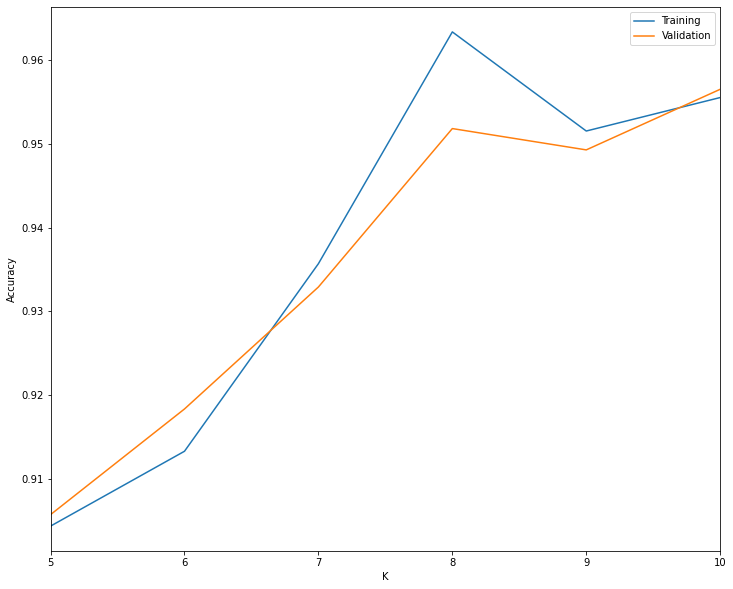

In [16]:
plt.rcParams['figure.figsize'] = [12, 10]
print(len(nbr_folds), len(avg_k_train_acc))
plt.plot(nbr_folds, avg_k_train_acc, label = 'Training')
plt.plot(nbr_folds, avg_k_val_acc, label= 'Validation')

plt.xlim([5, 10])
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('K')
# plt.title(Confidence Interval for KFCV)
plt.show()

# Fine-tuning

Get the model with the highest validation accuracy and perform the fine-tuning.  
Train the model using the whole training data for certain number of epochs without EARLY STOPPING.  
Change the optimzer, and choose smaller learning rate.

In [17]:
# loading the model with the highest validation accuracy
model_best_results = load_model('Best_model_saved')
for layer in model_best_results.layers:
    if 'conv3d' in layer.name: 
        layer.trainable = False # Freez the layers

In [18]:
start = time.time() # Start Timer

model_best_results.compile(loss = 'categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics = ['acc'])
model_best_results.fit(x = Xtrain, y = ytrain_enc, validation_data = (Xtest, ytest_enc), batch_size = 10, epochs = 50)

# Print Time it took to run
elapsed = time.time() - start
print(f'Elapsed time: {int(elapsed // 86400)}d {int((elapsed%86400) // 3600)}h {int((elapsed // 60) % 60)}m {int(elapsed%60)}s')

Epoch 1/50
36/36 [==============================] - 2s 53ms/step - loss: 0.4509 - acc: 0.8239 - val_loss: 0.9105 - val_acc: 0.5500
Epoch 2/50
36/36 [==============================] - 2s 52ms/step - loss: 0.3145 - acc: 0.8835 - val_loss: 0.6606 - val_acc: 0.6500
Epoch 3/50
36/36 [==============================] - 2s 51ms/step - loss: 0.2025 - acc: 0.9403 - val_loss: 0.6301 - val_acc: 0.7000
Epoch 4/50
36/36 [==============================] - 2s 52ms/step - loss: 0.1475 - acc: 0.9631 - val_loss: 0.5871 - val_acc: 0.7250
Epoch 5/50
36/36 [==============================] - 2s 52ms/step - loss: 0.0813 - acc: 0.9915 - val_loss: 0.7340 - val_acc: 0.7500
Epoch 6/50
36/36 [==============================] - 2s 52ms/step - loss: 0.0459 - acc: 1.0000 - val_loss: 0.7212 - val_acc: 0.7000
Epoch 7/50
36/36 [==============================] - 2s 51ms/step - loss: 0.0574 - acc: 1.0000 - val_loss: 0.7355 - val_acc: 0.7250
Epoch 8/50
36/36 [==============================] - 2s 51ms/step - loss: 0.0366 - a

# Evaluate the model with a Confution Matrix

Evaluate the model accuracy on the test set and compute the evaluation metrics (Confusion Matrix, Sensitivity, Specificity, and plot ROC curve).

In [19]:
output = model_best_results.predict(x = Xtest, batch_size = 5, use_multiprocessing = True)
con_matrix = confusion_matrix(y_true = ytest_enc.argmax(axis = 1), y_pred = output.argmax(axis = 1))

In [20]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}'.format(accuracy))
    plt.show()

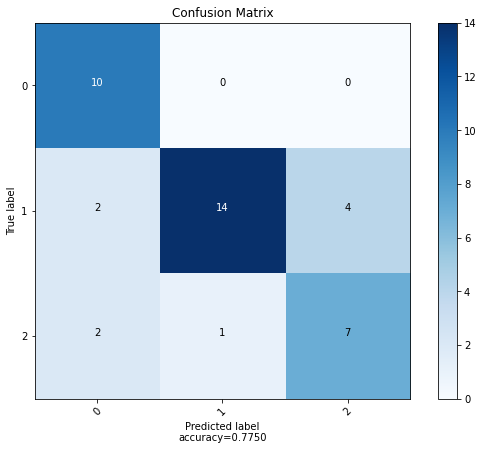

In [21]:
plot_confusion_matrix(cm           = con_matrix, 
                      normalize    = False,
                      target_names = ['0', '1', '2'],
                      title        = "Confusion Matrix")

# Sensitivity & Specificity

##### The matrix: 

[Cell1, Cell2, Cell3]  
[Cell4, Cell5, Cell6]  
[Cell7, Cell8, Cell9]

The true positive, true negative, false positive and false negative for each class would be calculated by adding the cell values as follows:

##### Class 0:
True Positive (TP) = Cell1  
False Positive (FP) = Cell2 + Cell3  
True Negative (NP) = Cell5 + Cell6 + Cell8 + Cell9  
False Negative (FN) = Cell4 + Cell7

##### Class 1:
TP = Cell5  
FP = Cell4 + Cell6  
TN = Cell1 + Cell3 + Cell7 + Cell9  
FN = Cell2 + Cell3

##### Class 2:
TP = Cell9  
FP = Cell7 + Cell8  
TN = Cell1 + Cell2 + Cell4 + Cell5  
FN = Cell3 + Cell6  

In [22]:
# Class 0
tp_0 = con_matrix[0][0] # Cell1
fp_0 = con_matrix[0][1] + con_matrix[0][2] # Cell2 + Cell3
tn_0 = con_matrix[1][1] + con_matrix[1][2] + con_matrix[2][1] + con_matrix[2][2] # Cell5 + Cell6 + Cell8 + Cell9
fn_0 = con_matrix[1][0] + con_matrix[2][0] # Cell4 + Cell7

# Class 1
tp_1 = con_matrix[1][1] # Cell5
fp_1 = con_matrix[1][0] + con_matrix[1][2] # Cell4 + Cell6
tn_1 = con_matrix[0][0] + con_matrix[0][2] + con_matrix[2][0] + con_matrix[2][2] # Cell1 + Cell3 + Cell7 + Cell9
fn_1 = con_matrix[0][1] + con_matrix[2][1] # Cell2 + Cell8

# Class 2
tp_2 = con_matrix[2][2] # Cell9
fp_2 = con_matrix[2][0] + con_matrix[2][1] # Cell7 + Cell8
tn_2 = con_matrix[0][0] + con_matrix[0][1] + con_matrix[1][0] + con_matrix[1][1] # Cell1 + Cell2 + Cell4 + Cell5
fn_2 = con_matrix[0][2] + con_matrix[1][2] # Cell3 + Cell6

In [23]:
def sensitivity(tp, fn, label):
    sensitivity = tp/(tp + fn)
    return(f'Class {label}\nSensitivity: {sensitivity}') 

In [24]:
def specificity(tn, fp, label):
    specificity = tn/(tn + fp)
    return(f'Class {label}\nSpecificity: {specificity}') 

In [25]:
print(sensitivity(tp_0, fn_0, 0), '\n')
print(specificity(tn_0, fp_0, 0))

Class 0
Sensitivity: 0.7142857142857143 

Class 0
Specificity: 1.0


In [26]:
print(sensitivity(tp_1, fn_1, 1), '\n')
print(specificity(tn_1, fp_1, 1))

Class 1
Sensitivity: 0.9333333333333333 

Class 1
Specificity: 0.76


In [27]:
print(sensitivity(tp_2, fn_2, 2), '\n')
print(specificity(tn_2, fp_2, 2))

Class 2
Sensitivity: 0.6363636363636364 

Class 2
Specificity: 0.896551724137931


# Plot ROC Curve

In [28]:
# Binarize the output
ytest_binarize = label_binarize(ytest, classes=[0, 1, 2])
n_classes = ytest_binarize.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytest_binarize[:, i], output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

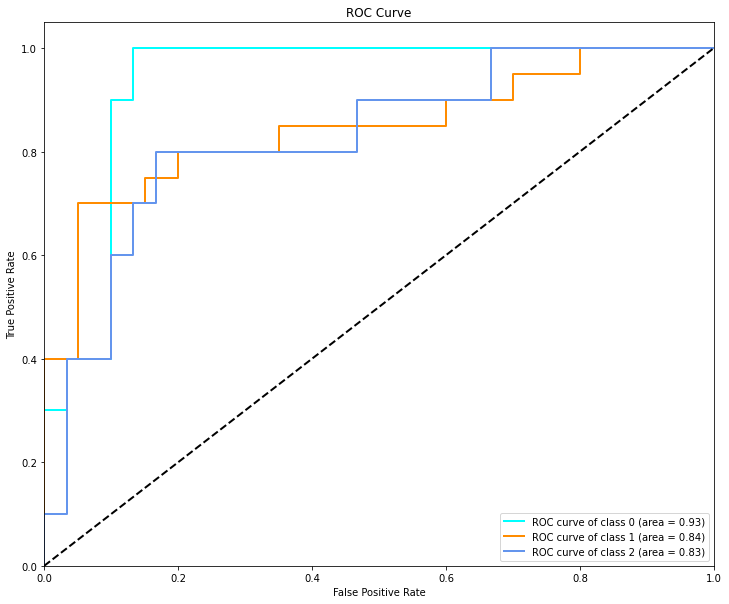

In [29]:
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(ytest_binarize.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()